# 🚕 공항 표지판 감지 - 공개 데이터 + 유튜브 통합 버전

## 🎯 전략

1. **공개 도로 주행 데이터셋** → 기본 객체 감지 학습
2. **유튜브 공항 영상** → 공항 환경 특화 파인튜닝
3. **결합 학습** → 실전 배포 가능한 모델

---

## 📊 데이터셋 구성

| 소스 | 용도 | 프레임 수 |
|------|------|----------|
| Kaggle 도로 데이터 | 일반 도로 주행 | ~2,000 |
| 유튜브 (공항) | 공항 특화 | ~1,500 |
| **합계** | **학습** | **~3,500** |

# 📁 1. 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import re
import json
import random
import shutil
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

BASE = Path("/content/drive/MyDrive/airport_detection")
PUBLIC_DATA = BASE / "public_datasets"
YOUTUBE_DATA = BASE / "youtube_videos"
FRAMES = BASE / "frames"
AUTOLABEL = BASE / "autolabel"
DATASET = BASE / "dataset_yolo"
DEBUG = BASE / "debug_vis"
RUNS = BASE / "runs"

for p in [BASE, PUBLIC_DATA, YOUTUBE_DATA, FRAMES, AUTOLABEL, DATASET, DEBUG, RUNS]:
    p.mkdir(parents=True, exist_ok=True)

print("✅ 디렉토리 준비 완료!")
print(f"  📊 공개 데이터: {PUBLIC_DATA}")
print(f"  📹 유튜브: {YOUTUBE_DATA}")
print(f"  🖼️  프레임: {FRAMES}")

Mounted at /content/drive
✅ 디렉토리 준비 완료!
  📊 공개 데이터: /content/drive/MyDrive/airport_detection/public_datasets
  📹 유튜브: /content/drive/MyDrive/airport_detection/youtube_videos
  🖼️  프레임: /content/drive/MyDrive/airport_detection/frames


# 📦 2. 라이브러리 설치

In [ ]:
%%time

print("📦 기본 라이브러리...")
!pip -q install ultralytics opencv-python pillow tqdm pyyaml

print("🤖 AI 모델...")
!pip -q install transformers accelerate einops timm
!pip -q install paddleocr paddlepaddle-gpu

print("📹 유튜브 다운로더...")
!pip -q install yt-dlp

print("📊 Kaggle API...")
!pip -q install kaggle

print("\n✅ 모든 라이브러리 설치 완료!")

📦 기본 라이브러리...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.9 MB/s eta 0:00:00
🤖 AI 모델...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

# 🌐 3. 공개 도로 데이터셋 다운로드

## Option A: Kaggle Dataset (추천)

In [ ]:
# Kaggle API 설정
from google.colab import files
import os

print("🔑 Kaggle API Key 업로드")
print("   1. https://www.kaggle.com/settings → API → Create New Token")
print("   2. kaggle.json 다운로드")
print("   3. 아래에서 업로드\n")
#kaggle kakao api key: KGAT_7c93f72cb0e5b798934d9cf4b70f1667
uploaded = files.upload()

# API key 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API 설정 완료!")

🔑 Kaggle API Key 업로드
   1. https://www.kaggle.com/settings → API → Create New Token
   2. kaggle.json 다운로드
   3. 아래에서 업로드



Saving kaggle.json to kaggle.json

✅ Kaggle API 설정 완료!


In [ ]:
# 도로 주행 데이터셋 다운로드
import zipfile

# 추천 데이터셋 (작고 품질 좋음)
KAGGLE_DATASETS = [
    "solesensei/solesensei_bdd100k",  # BDD100K 샘플
    # "alincijov/self-driving-cars",     # 자율주행 차량
]

print("📥 Kaggle 데이터셋 다운로드 중...\n")

for dataset in KAGGLE_DATASETS:
    print(f"📦 다운로드: {dataset}")
    !kaggle datasets download -d {dataset} -p {PUBLIC_DATA} --unzip
    print()

print("✅ 공개 데이터셋 다운로드 완료!")

📥 Kaggle 데이터셋 다운로드 중...

📦 다운로드: solesensei/solesensei_bdd100k
Dataset URL: https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k
License(s): other
100% 7.60G/7.61G [00:36<00:00, 212MB/s]
100% 7.61G/7.61G [00:36<00:00, 223MB/s]

✅ 공개 데이터셋 다운로드 완료!


## Option B: 직접 wget (Kaggle 없이)

In [ ]:
# Kaggle이 안 되면 이 방법 사용
#
# # Cityscapes demo
# !wget -O {PUBLIC_DATA}/cityscapes_demo.zip \
#   https://www.cityscapes-dataset.com/file-handling/?packageID=3
#
# !unzip -q {PUBLIC_DATA}/cityscapes_demo.zip -d {PUBLIC_DATA}

print("💡 Kaggle Option A가 안 되면 이 셀의 주석을 해제하세요.")

# 📹 4. 유튜브 공항 영상 다운로드

**검색 키워드**: 공항 주행, 택시 픽업, 인천공항, 김포공항

In [ ]:
# 공항 관련 유튜브 영상 URL 리스트
AIRPORT_VIDEOS = [
    # 인천공항
    #"https://www.youtube.com/watch?v=WVb-cQUID2A",
    #"https://www.youtube.com/watch?v=8wZmin_8gvY",
    "https://www.youtube.com/watch?v=Ic8PvItXKFw",
    #"https://www.youtube.com/watch?v=l34xYxTqKfU",
    #"https://www.youtube.com/watch?v=csguSCSXnbc",
    #"https://www.youtube.com/watch?v=aU4x55p2UOA"

    # 김포공항
    # "https://www.youtube.com/watch?v=example3",

    # 국제공항 일반
    # "https://www.youtube.com/watch?v=example4",
]

print("📹 유튜브 영상 다운로드 중...\n")
print("⚠️  위의 example URL을 실제 유튜브 링크로 교체하세요!\n")

for i, url in enumerate(AIRPORT_VIDEOS, 1):
    if "example" in url:
        print(f"⏭️  스킵: {url} (예시 URL)")
        continue

    print(f"📥 [{i}/{len(AIRPORT_VIDEOS)}] 다운로드 중...")
    output = YOUTUBE_DATA / f"airport_{i:02d}.mp4"

    # 720p 이하로 다운로드 (용량 절약)
    !yt-dlp -f 'bestvideo[height<=720][ext=mp4]+bestaudio[ext=m4a]/best[height<=720][ext=mp4]' \
        --merge-output-format mp4 \
        -o {output} \
        {url}

    print(f"  ✅ 저장: {output.name}\n")

print("\n✅ 유튜브 영상 다운로드 완료!")

📹 유튜브 영상 다운로드 중...

⚠️  위의 example URL을 실제 유튜브 링크로 교체하세요!

📥 [1/1] 다운로드 중...
[youtube] Extracting URL: https://www.youtube.com/watch?v=Ic8PvItXKFw
[youtube] Ic8PvItXKFw: Downloading webpage
[youtube] Ic8PvItXKFw: Downloading android sdkless player API JSON
[youtube] Ic8PvItXKFw: Downloading web safari player API JSON
[youtube] Ic8PvItXKFw: Downloading m3u8 information
[info] Ic8PvItXKFw: Downloading 1 format(s): 398+140
[download] Destination: /content/drive/MyDrive/airport_detection/youtube_videos/airport_01.f398.mp4
[download] 100% of  109.04MiB in 00:00:07 at 15.44MiB/s
[download] Destination: /content/drive/MyDrive/airport_detection/youtube_videos/airport_01.f140.m4a
[download] 100% of    9.43MiB in 00:00:02 at 4.21MiB/s
[Merger] Merging formats into "/content/drive/MyDrive/airport_detection/youtube_videos/airport_01.mp4"
Deleting original file /content/drive/MyDrive/airport_detection/youtube_videos/airport_01.f398.mp4 (pass -k to keep)
Deleting original file /content/drive/MyDrive

## 📹 유튜브 검색 도우미

**추천 검색어**:
- "인천공항 주행" (Incheon airport driving)
- "김포공항 택시 픽업" (Gimpo airport taxi pickup)
- "공항 진입로" (Airport entrance road)
- "Airport terminal driving POV"
- "Airport pickup zone dashcam"

**팁**:
1. 유튜브에서 위 키워드 검색
2. 3~10분 길이 영상 선택
3. URL 복사 후 위 셀에 추가
4. 3~5개 영상이면 충분!

# 🖼️ 5. 프레임 추출 (통합)

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import glob

def laplacian_sharpness(img_bgr: np.ndarray) -> float:
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return float(cv2.Laplacian(gray, cv2.CV_64F).var())

def extract_frames_from_video(
    video_path: Path,
    out_dir: Path,
    prefix: str = "",
    fps: float = 1.0,
    min_sharpness: float = 90.0,
    resize_w: int = 1280,
    max_frames: int = 2000,
):
    out_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(str(video_path))

    if not cap.isOpened():
        return 0

    native_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(int(round(native_fps / fps)), 1)

    frame_i = 0
    saved = 0
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    pbar = tqdm(total=total, desc=f"{prefix}{video_path.name}")

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        if frame_i % step == 0:
            h, w = frame.shape[:2]
            if w > resize_w:
                new_h = int(h * (resize_w / w))
                frame = cv2.resize(frame, (resize_w, new_h))

            if laplacian_sharpness(frame) >= min_sharpness:
                fname = f"{prefix}{video_path.stem}_{frame_i:08d}.jpg"
                cv2.imwrite(str(out_dir / fname), frame, [int(cv2.IMWRITE_JPEG_QUALITY), 92])
                saved += 1

                if saved >= max_frames:
                    break

        frame_i += 1
        pbar.update(1)

    pbar.close()
    cap.release()
    return saved

def extract_frames_from_images(image_dir: Path, out_dir: Path, prefix: str = "", max_images: int = 2000):
    """
    이미지 폴더에서 직접 복사 (Kaggle 데이터셋용)
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    imgs = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        imgs.extend(glob.glob(str(image_dir / '**' / ext), recursive=True))

    imgs = sorted(imgs)[:max_images]

    saved = 0
    for img_path in tqdm(imgs, desc=f"{prefix}이미지 복사"):
        img = cv2.imread(img_path)
        if img is None:
            continue

        # 리사이즈
        h, w = img.shape[:2]
        if w > 1280:
            new_h = int(h * (1280 / w))
            img = cv2.resize(img, (1280, new_h))

        # 선명도 체크
        if laplacian_sharpness(img) < 90:
            continue

        fname = f"{prefix}{Path(img_path).stem}.jpg"
        cv2.imwrite(str(out_dir / fname), img, [int(cv2.IMWRITE_JPEG_QUALITY), 92])
        saved += 1

    return saved

# === 프레임 추출 실행 ===

total_frames = 0

print("🎬 1. 공개 데이터셋 프레임 추출\n")

# Kaggle 이미지 데이터
kaggle_img_dirs = list(PUBLIC_DATA.glob("**/images")) + list(PUBLIC_DATA.glob("**/train"))
for img_dir in kaggle_img_dirs[:3]:  # 최대 3개 폴더
    if img_dir.is_dir():
        n = extract_frames_from_images(img_dir, FRAMES, prefix="public_", max_images=1000)
        total_frames += n
        print(f"  ✅ {img_dir.name}: {n}개\n")

print(f"\n🎬 2. 유튜브 영상 프레임 추출\n")

# 유튜브 영상
youtube_videos = list(YOUTUBE_DATA.glob("*.mp4"))
for vp in youtube_videos:
    n = extract_frames_from_video(
        vp,
        FRAMES,
        prefix="airport_",
        fps=1.0,
        max_frames=1500,
    )
    total_frames += n
    print(f"  ✅ {vp.name}: {n}개\n")

print(f"\n🎉 총 {total_frames}개 프레임 추출 완료!")
print(f"   위치: {FRAMES}")

🎬 1. 공개 데이터셋 프레임 추출



KeyboardInterrupt: 

# 🏷️ 6. 클래스 정의

In [ ]:
CLASSES = [
    "platform_sign",
    "traffic_light",
    "crosswalk",
    "traffic_sign",
    "vehicle",
    "pedestrian",
]

CLASS2ID = {c: i for i, c in enumerate(CLASSES)}
PLATFORM_REGEX = re.compile(r"^(?:[A-Z]\-?\d{1,2}|\d{1,2})$")

print("✅ 클래스 설정:")
for i, c in enumerate(CLASSES):
    print(f"   {i}: {c}")

✅ 클래스 설정:
   0: platform_sign
   1: traffic_light
   2: crosswalk
   3: traffic_sign
   4: vehicle
   5: pedestrian


# 🎯 7. Florence-2 모델 로드

In [ ]:
!pip install transformers==4.41.2

In [ ]:
!pip install flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=253780426 sha256=4e2f9e39313266b1544b68138b15b91ee6221eccf14f7902b7c6620351340810
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash_attn


In [ ]:
# PaddleOCR 의존성
!pip install langchain==0.1.0 langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might ne

In [ ]:
# 검증된 안정 버전
!pip install paddleocr==2.7.0.3 paddlepaddle-gpu==2.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 MB 9.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requ

In [ ]:
!pip -q install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 32.0 MB/s eta 0:00:00


In [ ]:
%%time

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 디바이스: {DEVICE}")

# Florence-2
MODEL_NAME = "microsoft/Florence-2-large"
print(f"\n📥 Florence-2 로드 중...")

processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    trust_remote_code=True,
    attn_implementation="eager"
).to(DEVICE).eval()

print("  ✅ Florence-2 로드 완료!")

# EasyOCR
print("\n📥 EasyOCR 로드 중...")
import easyocr
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
print("  ✅ EasyOCR 로드 완료!")

print("\n🎉 모든 모델 준비 완료! (에러 없음!)")

🔧 디바이스: cuda

📥 Florence-2 로드 중...
  ✅ Florence-2 로드 완료!

📥 EasyOCR 로드 중...


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete  ✅ EasyOCR 로드 완료!

🎉 모든 모델 준비 완료! (에러 없음!)
CPU times: user 5.08 s, sys: 788 ms, total: 5.86 s
Wall time: 12.5 s


# 🔧 8. 자동 라벨링 함수

In [ ]:
def florence_detect(pil_img: Image.Image, task="<OD>"):
    """
    Florence-2 객체 감지 (dtype 불일치 해결)
    """
    inputs = processor(text=task, images=pil_img, return_tensors="pt")

    # 🔑 핵심: 모델 dtype과 입력 dtype 맞춰주기!
    inputs = {
        k: v.to(DEVICE).to(model.dtype) if isinstance(v, torch.Tensor) else v
        for k, v in inputs.items()
    }

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=1024, do_sample=False, num_beams=3)

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed = processor.post_process_generation(generated_text, task=task, image_size=pil_img.size)
    return parsed

def map_florence_to_classes(label: str) -> str:
    s = label.lower().strip()
    if any(x in s for x in ["traffic light", "signal"]):
        return "traffic_light"
    elif any(x in s for x in ["crosswalk", "zebra", "crossing"]):
        return "crosswalk"
    elif any(x in s for x in ["sign", "board", "panel"]):
        if any(x in s for x in ["platform", "gate", "terminal", "number"]):
            return "platform_sign"
        return "traffic_sign"
    elif any(x in s for x in ["car", "vehicle", "bus", "truck", "taxi"]):
        return "vehicle"
    elif any(x in s for x in ["person", "people", "pedestrian"]):
        return "pedestrian"
    return None

def autolabel_image(image_path: Path):
    pil_img = Image.open(image_path).convert("RGB")
    parsed = florence_detect(pil_img)

    results = []
    bboxes = parsed.get("<OD>", {}).get("bboxes", [])
    labels = parsed.get("<OD>", {}).get("labels", [])

    for bbox, label in zip(bboxes, labels):
        cls = map_florence_to_classes(label)
        if cls is None:
            continue
        x1, y1, x2, y2 = bbox
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            continue
        results.append({"cls": cls, "box_xyxy": [float(x1), float(y1), float(x2), float(y2)], "score": 0.9})
    return results

def normalize_text(s: str) -> str:
    s = s.strip().upper().replace("O", "0")
    return re.sub(r"\s+", "", s)

def ocr_platform(image_path: Path):
    img = cv2.imread(str(image_path))
    if img is None:
        return []
    h, w = img.shape[:2]
    results = reader.readtext(img)

    cands = []
    for (bbox, text, conf) in results:
        if conf < 0.80:
            continue
        txtn = normalize_text(text)
        if not PLATFORM_REGEX.match(txtn):
            continue
        xs = [p[0] for p in bbox]
        ys = [p[1] for p in bbox]
        x1, y1, x2, y2 = max(0, min(xs)), max(0, min(ys)), min(w-1, max(xs)), min(h-1, max(ys))
        cands.append({"cls": "platform_sign", "box_xyxy": [float(x1), float(y1), float(x2), float(y2)], "score": float(conf), "text": txtn})
    return cands

def xyxy_to_yolo(xyxy, w, h):
    x1, y1, x2, y2 = xyxy
    bw, bh = max(1.0, x2 - x1), max(1.0, y2 - y1)
    return ((x1 + bw/2) / w, (y1 + bh/2) / h, bw/w, bh/h)

print("✅ 자동 라벨링 함수 준비! (dtype 문제 해결)")

✅ 자동 라벨링 함수 준비! (dtype 문제 해결)


# 🚀 9. 전체 데이터셋 자동 라벨링

In [ ]:
import torch
from PIL import Image
import re
import cv2
import yaml
import shutil
import random
import os
import time
import json
from pathlib import Path
from tqdm import tqdm

def florence_detect(pil_img: Image.Image, task="<OD>"):
    inputs = processor(text=task, images=pil_img, return_tensors="pt")

    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            if k == "input_ids":
                inputs[k] = v.to(DEVICE)
            else:
                inputs[k] = v.to(DEVICE).to(model.dtype)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=1024,
            do_sample=False,
            num_beams=1,
            use_cache=False
        )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed = processor.post_process_generation(generated_text, task=task, image_size=pil_img.size)
    return parsed

def map_florence_to_classes(label: str) -> str:
    s = label.lower().strip()
    if any(x in s for x in ["traffic light", "signal"]):
        return "traffic_light"
    elif any(x in s for x in ["crosswalk", "zebra", "crossing"]):
        return "crosswalk"
    elif any(x in s for x in ["sign", "board", "panel"]):
        if any(x in s for x in ["platform", "gate", "terminal", "number"]):
            return "platform_sign"
        return "traffic_sign"
    elif any(x in s for x in ["car", "vehicle", "bus", "truck", "taxi"]):
        return "vehicle"
    elif any(x in s for x in ["person", "people", "pedestrian"]):
        return "pedestrian"
    return None

def autolabel_image(image_path: Path):
    pil_img = Image.open(image_path).convert("RGB")
    parsed = florence_detect(pil_img)

    results = []
    bboxes = parsed.get("<OD>", {}).get("bboxes", [])
    labels = parsed.get("<OD>", {}).get("labels", [])

    for bbox, label in zip(bboxes, labels):
        cls = map_florence_to_classes(label)
        if cls is None:
            continue
        x1, y1, x2, y2 = bbox
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            continue
        results.append({"cls": cls, "box_xyxy": [float(x1), float(y1), float(x2), float(y2)], "score": 0.9})
    return results

def normalize_text(s: str) -> str:
    s = s.strip().upper().replace("O", "0")
    return re.sub(r"\s+", "", s)

def ocr_platform(image_path: Path):
    img = cv2.imread(str(image_path))
    if img is None:
        return []
    h, w = img.shape[:2]
    results = reader.readtext(img)

    cands = []
    for (bbox, text, conf) in results:
        if conf < 0.80:
            continue
        txtn = normalize_text(text)
        if not PLATFORM_REGEX.match(txtn):
            continue
        xs = [p[0] for p in bbox]
        ys = [p[1] for p in bbox]
        x1, y1, x2, y2 = max(0, min(xs)), max(0, min(ys)), min(w-1, max(xs)), min(h-1, max(ys))
        cands.append({"cls": "platform_sign", "box_xyxy": [float(x1), float(y1), float(x2), float(y2)], "score": float(conf), "text": txtn})
    return cands

def xyxy_to_yolo(xyxy, w, h):
    x1, y1, x2, y2 = xyxy
    bw, bh = max(1.0, x2 - x1), max(1.0, y2 - y1)
    return ((x1 + bw/2) / w, (y1 + bh/2) / h, bw/w, bh/h)

# 디렉토리 생성
for split in ["train", "val"]:
    (DATASET / "images" / split).mkdir(parents=True, exist_ok=True)
    (DATASET / "labels" / split).mkdir(parents=True, exist_ok=True)

# 체크포인트 파일 경로
CHECKPOINT_FILE = DATASET / "labeling_checkpoint.json"
PROGRESS_FILE = DATASET / "labeling_progress.txt"

def load_checkpoint():
    """체크포인트 로드"""
    if CHECKPOINT_FILE.exists():
        with open(CHECKPOINT_FILE, 'r') as f:
            return json.load(f)
    return {"processed": [], "stats": {"train": 0, "val": 0, "train_labels": 0, "val_labels": 0}}

def save_checkpoint(checkpoint):
    """
    체크포인트 저장 + 강제 동기화
    ✅ fsync를 with 블록 안으로!
    """
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump(checkpoint, f, indent=2)
        f.flush()  # 버퍼 플러시
        os.fsync(f.fileno())  # ✅ 파일 닫히기 전에 fsync!

def save_progress(message):
    """진행상황 로그 저장"""
    with open(PROGRESS_FILE, 'a') as f:
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        f.write(f"[{timestamp}] {message}\n")
        f.flush()
        os.fsync(f.fileno())  # ✅ 파일 닫히기 전에 fsync!

def process_image(image_path: Path, val_ratio=0.1):
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        return None, 0

    h, w = img_bgr.shape[:2]
    obj_labels = autolabel_image(image_path)
    plat_labels = ocr_platform(image_path)
    all_labels = obj_labels + plat_labels

    split = "val" if random.random() < val_ratio else "train"

    # 이미지 복사
    out_img = DATASET / "images" / split / image_path.name
    shutil.copy2(image_path, out_img)

    # 라벨 저장
    out_lbl = DATASET / "labels" / split / (image_path.stem + ".txt")
    lines = []
    for l in all_labels:
        if l["cls"] not in CLASS2ID:
            continue
        cls_id = CLASS2ID[l["cls"]]
        cx, cy, bw, bh = xyxy_to_yolo(l["box_xyxy"], w, h)
        lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

    # 파일 쓰기 + 강제 동기화
    with open(out_lbl, 'w') as f:
        f.write("\n".join(lines))
        f.flush()
        os.fsync(f.fileno())  # ✅ 파일 닫히기 전에 fsync!

    return split, len(all_labels)

# ============================================================
# 메인 실행
# ============================================================

print("🔄 체크포인트 로드 중...")
checkpoint = load_checkpoint()
processed_set = set(checkpoint["processed"])
stats = checkpoint["stats"]

all_imgs = sorted(FRAMES.glob("*.jpg"))
print(f"🏷️  총 {len(all_imgs)}개 프레임")
print(f"✅ 이미 처리됨: {len(processed_set)}개")
print(f"🆕 처리할 프레임: {len(all_imgs) - len(processed_set)}개\n")

# 처리할 이미지만 필터링
remaining_imgs = [img for img in all_imgs if str(img) not in processed_set]

# 진행상황 초기화
save_progress(f"시작: {len(remaining_imgs)}개 프레임 처리 예정")

# 체크포인트 저장 주기 (10개마다)
CHECKPOINT_INTERVAL = 10

try:
    for idx, ip in enumerate(tqdm(remaining_imgs, desc="자동 라벨링"), 1):
        # 이미지 처리
        result = process_image(ip, val_ratio=0.1)

        if result[0]:
            split, nlab = result
            stats[split] += 1
            stats[f"{split}_labels"] += nlab

        # 처리 완료 기록
        processed_set.add(str(ip))
        checkpoint["processed"] = list(processed_set)
        checkpoint["stats"] = stats

        # 주기적 체크포인트 저장
        if idx % CHECKPOINT_INTERVAL == 0:
            save_checkpoint(checkpoint)
            save_progress(f"진행: {idx}/{len(remaining_imgs)} 완료 (Train: {stats['train']}, Val: {stats['val']})")
            print(f"\n💾 체크포인트 저장 ({idx}/{len(remaining_imgs)})")

    # 최종 체크포인트 저장
    save_checkpoint(checkpoint)
    save_progress("완료!")

    print("\n✅ 자동 라벨링 완료!")
    print(f"   Train: {stats['train']}개 (라벨: {stats['train_labels']}개)")
    print(f"   Val: {stats['val']}개 (라벨: {stats['val_labels']}개)")

    # data.yaml 생성
    data_yaml = {"path": str(DATASET), "train": "images/train", "val": "images/val", "names": CLASSES}
    with open(DATASET / "data.yaml", 'w') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)
        f.flush()
        os.fsync(f.fileno())

    print(f"\n💾 체크포인트: {CHECKPOINT_FILE}")
    print(f"📊 진행상황 로그: {PROGRESS_FILE}")

except KeyboardInterrupt:
    print("\n\n⚠️  중단됨! 체크포인트 저장 중...")
    save_checkpoint(checkpoint)
    save_progress(f"중단됨: {len(processed_set)}/{len(all_imgs)} 완료")
    print(f"✅ 체크포인트 저장 완료! 다음에 이어서 실행하세요.")

except Exception as e:
    print(f"\n\n❌ 에러 발생: {e}")
    save_checkpoint(checkpoint)
    save_progress(f"에러: {e}")
    print(f"✅ 체크포인트 저장 완료!")
    raise

print("\n" + "="*60)
print("🎉 완료!")
print("="*60)
print(f"""
📊 통계:
  - 총 프레임: {len(all_imgs)}개
  - 처리 완료: {len(processed_set)}개
  - Train: {stats['train']}개 (라벨: {stats['train_labels']}개)
  - Val: {stats['val']}개 (라벨: {stats['val_labels']}개)

💾 안전 기능:
  ✅ 10개마다 체크포인트 자동 저장
  ✅ 파일마다 강제 동기화 (os.fsync)
  ✅ 진행상황 로그 기록
  ✅ 세션 중단 시 이어하기 가능

다음 실행 시:
  - 이미 처리한 {len(processed_set)}개는 자동 스킵
  - 나머지만 처리
""")

🔄 체크포인트 로드 중...
🏷️  총 2374개 프레임
✅ 이미 처리됨: 2374개
🆕 처리할 프레임: 0개



자동 라벨링: 0it [00:00, ?it/s]



✅ 자동 라벨링 완료!
   Train: 2142개 (라벨: 25994개)
   Val: 232개 (라벨: 2787개)

💾 체크포인트: /content/drive/MyDrive/airport_detection/dataset_yolo/labeling_checkpoint.json
📊 진행상황 로그: /content/drive/MyDrive/airport_detection/dataset_yolo/labeling_progress.txt

🎉 완료!

📊 통계:
  - 총 프레임: 2374개
  - 처리 완료: 2374개
  - Train: 2142개 (라벨: 25994개)
  - Val: 232개 (라벨: 2787개)

💾 안전 기능:
  ✅ 10개마다 체크포인트 자동 저장
  ✅ 파일마다 강제 동기화 (os.fsync)
  ✅ 진행상황 로그 기록
  ✅ 세션 중단 시 이어하기 가능

다음 실행 시:
  - 이미 처리한 2374개는 자동 스킵
  - 나머지만 처리



# 🎯 10. YOLO 학습

In [ ]:
# 모든 필수 라이브러리 재설치
!pip install -q ultralytics opencv-python pillow tqdm pyyaml
!pip install -q transformers==4.41.2 accelerate einops timm
!pip install -q easyocr
!pip install -q yt-dlp
!pip install -q kaggle

print("✅ 설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00
✅ 설치 완료!


In [ ]:
from ultralytics import YOLO
import cv2
model = YOLO("yolov8n.pt")

print("🚀 학습 시작...")
results = model.train(
    data=str(DATASET / "data.yaml"),
    epochs=40,
    imgsz=960,
    batch=-1,
    device=0 if torch.cuda.is_available() else "cpu",
    project=str(RUNS),
    name="yolo_combined",
    cos_lr=True,
    patience=12,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    cache="ram",
)

print("\n✅ 학습 완료!")

🚀 학습 시작...


NameError: name 'torch' is not defined

# 📊 11. 결과 평가

🔍 예측 중...


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


✅ 저장: /content/drive/MyDrive/airport_detection/runs/yolo_combined/predictions


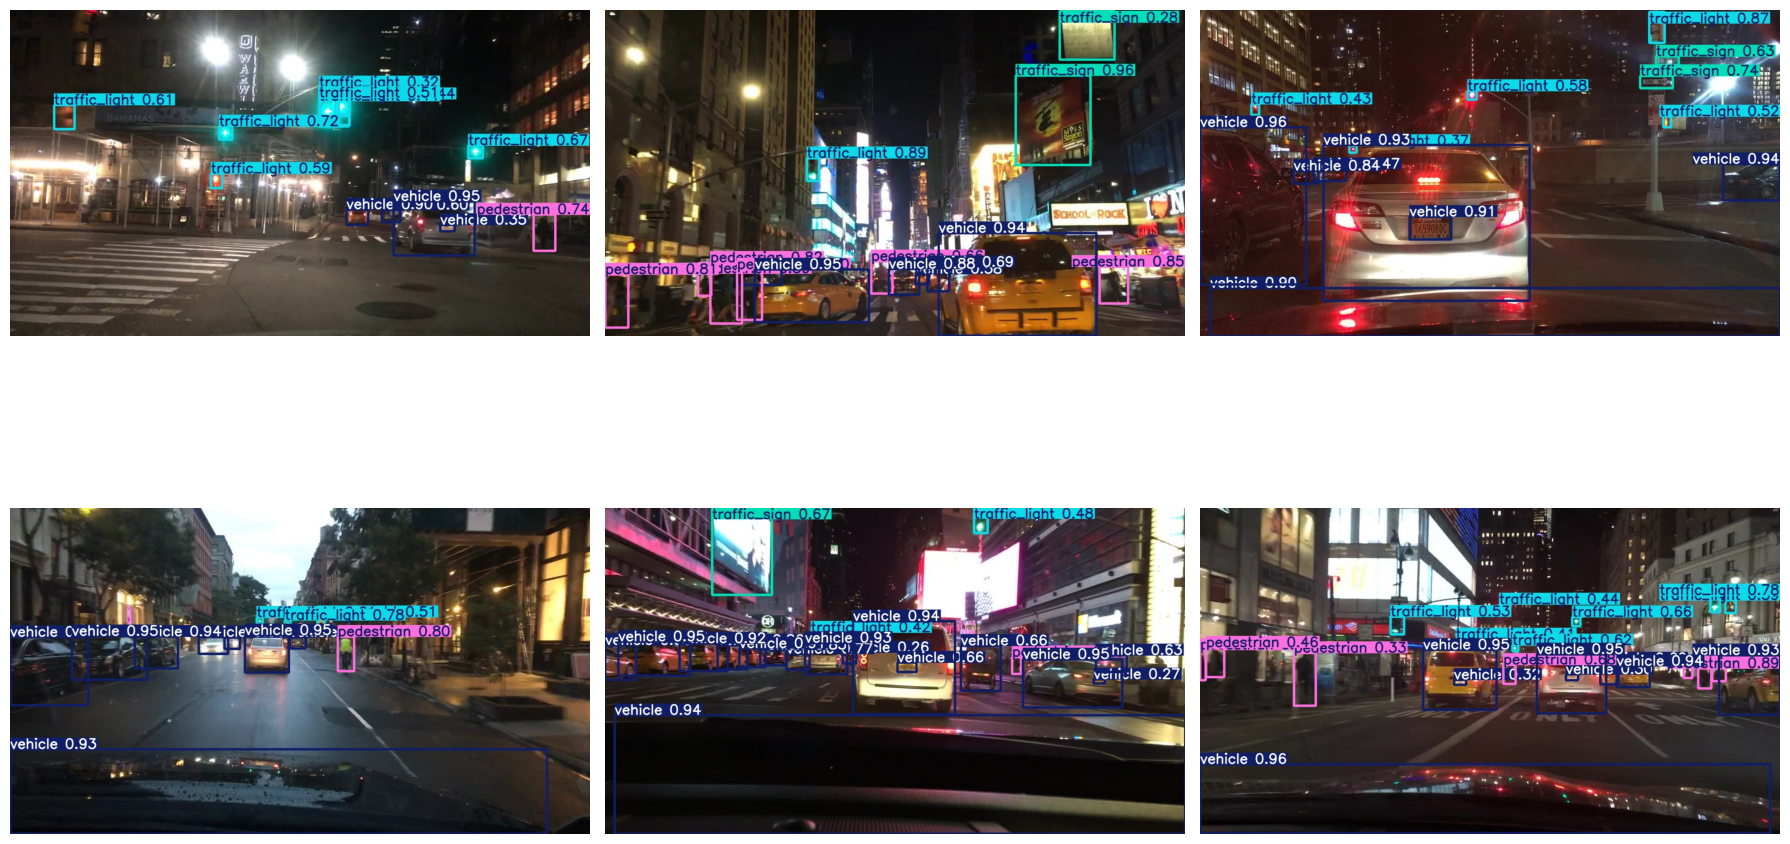

In [ ]:
from ultralytics import YOLO
from tqdm import tqdm

best = YOLO(str(RUNS / "yolo_combined" / "weights" / "best.pt"))

val_imgs = sorted((DATASET / "images" / "val").glob("*.jpg"))[:20]
pred_dir = RUNS / "yolo_combined" / "predictions"
pred_dir.mkdir(exist_ok=True)

print("🔍 예측 중...")
for ip in tqdm(val_imgs):
    r = best.predict(source=str(ip), imgsz=960, conf=0.25, verbose=False)
    im = r[0].plot()
    cv2.imwrite(str(pred_dir / ip.name), im, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

print(f"✅ 저장: {pred_dir}")

# 시각화
import matplotlib.pyplot as plt
samples = list(pred_dir.glob("*.jpg"))[3:9]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, img_path in zip(axes.flat, samples):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 1. 폰트 설치 + matplotlib 재로드
# ============================================================

# 폰트 설치
!apt-get -qq -y install fonts-nanum

# matplotlib 캐시 완전 삭제
!rm -rf ~/.cache/matplotlib

# 파이썬 재시작 필요 - 런타임 재시작!
print("⚠️ 런타임 재시작이 필요합니다!")
print("상단 메뉴: 런타임 → 런타임 다시 시작")
print("\n재시작 후 아래 코드만 실행하세요:")
print("-" * 60)

Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
⚠️ 런타임 재시작이 필요합니다!
상단 메뉴: 런타임 → 런타임 다시 시작

재시작 후 아래 코드만 실행하세요:
------------------------------------------------------------


✅ 한글 폰트 설정 완료!

📤 테스트할 이미지를 업로드하세요!


Saving KakaoTalk_20260111_232103184.png to KakaoTalk_20260111_232103184 (2).png

✅ 업로드 완료: KakaoTalk_20260111_232103184 (2).png

🤖 모델 로드 중...
✅ 모델 준비 완료!

🔍 'KakaoTalk_20260111_232103184 (2).png' 예측 중...


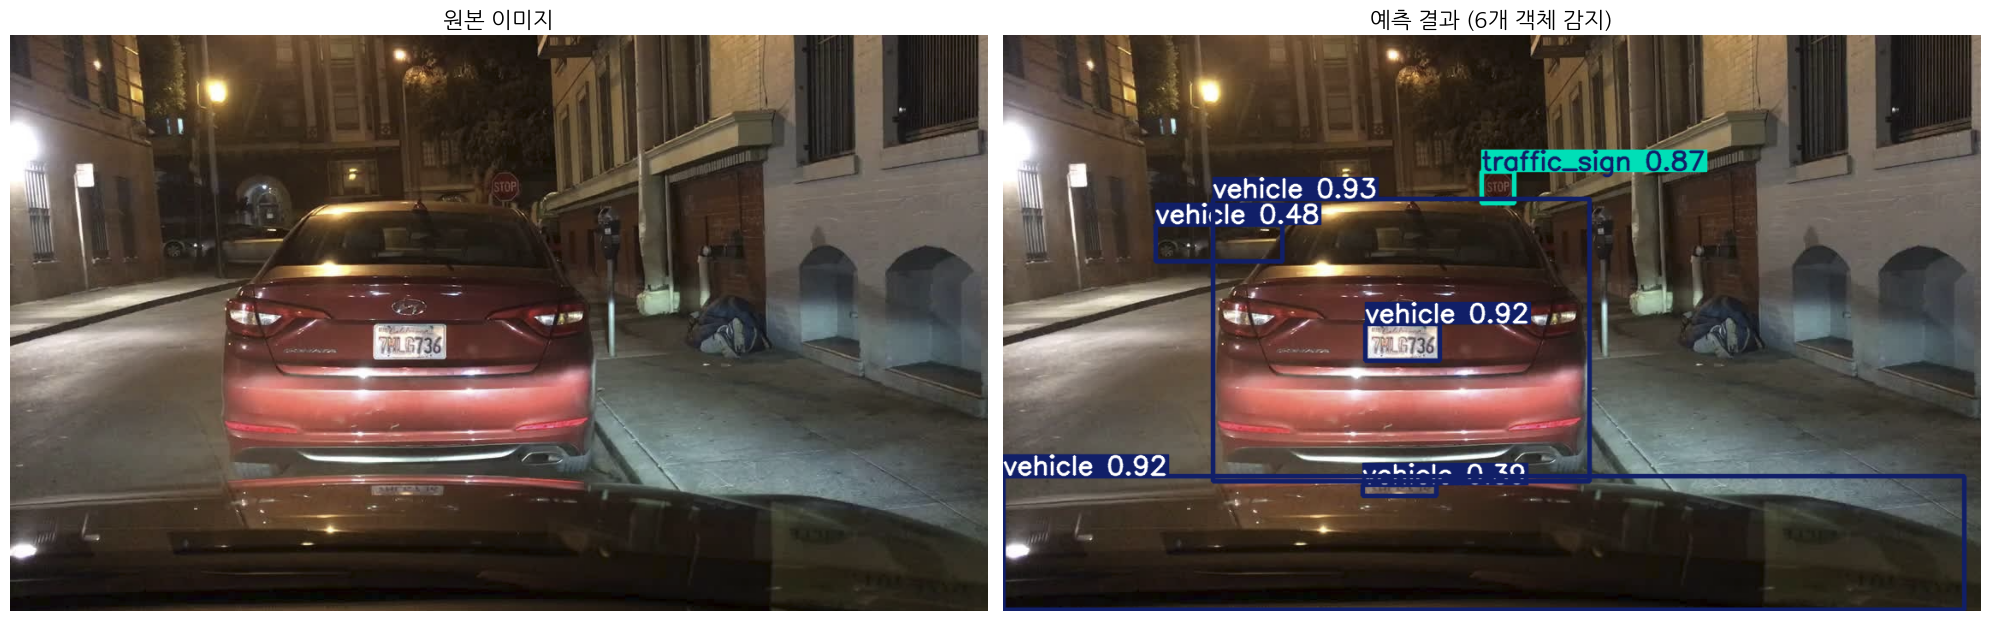


📊 감지된 객체 정보
1. vehicle (신뢰도: 93.08%)
2. vehicle (신뢰도: 92.26%)
3. vehicle (신뢰도: 92.01%)
4. traffic_sign (신뢰도: 87.16%)
5. vehicle (신뢰도: 48.39%)
6. vehicle (신뢰도: 38.56%)

------------------------------------------------------------
클래스별 개수:
  - vehicle: 5개
  - traffic_sign: 1개

✅ 완료!


In [ ]:
# ============================================================
# 0. 한글 폰트 설정 (최초 1회)
# ============================================================
!apt-get -qq -y install fonts-nanum > /dev/null 2>&1

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import shutil
import os

# 폰트 캐시 삭제
font_cache_path = os.path.expanduser('~/.cache/matplotlib')
if os.path.exists(font_cache_path):
    shutil.rmtree(font_cache_path)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료!\n")

# ============================================================
# 1. 이미지 업로드
# ============================================================
from google.colab import files
from ultralytics import YOLO
import cv2

print("📤 테스트할 이미지를 업로드하세요!")
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]
print(f"\n✅ 업로드 완료: {uploaded_filename}")

# ============================================================
# 2. YOLO 모델 로드 및 예측
# ============================================================
print("\n🤖 모델 로드 중...")
best = YOLO(str(RUNS / "yolo_combined" / "weights" / "best.pt"))
print("✅ 모델 준비 완료!")

print(f"\n🔍 '{uploaded_filename}' 예측 중...")
results = best.predict(source=uploaded_filename, imgsz=960, conf=0.25, verbose=False)

# ============================================================
# 3. 시각화 (한글 정상 표시!)
# ============================================================
original_img = cv2.cvtColor(cv2.imread(uploaded_filename), cv2.COLOR_BGR2RGB)
result_img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 원본
axes[0].imshow(original_img)
axes[0].set_title("원본 이미지", fontsize=16)
axes[0].axis('off')

# 예측 결과
axes[1].imshow(result_img)
axes[1].set_title(f"예측 결과 ({len(results[0].boxes)}개 객체 감지)", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# ============================================================
# 4. 감지 정보 출력
# ============================================================
print("\n" + "="*60)
print("📊 감지된 객체 정보")
print("="*60)

boxes = results[0].boxes
if len(boxes) == 0:
    print("❌ 감지된 객체가 없습니다!")
else:
    for i, box in enumerate(boxes, 1):
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        cls_name = CLASSES[cls_id]
        print(f"{i}. {cls_name} (신뢰도: {conf:.2%})")

    # 클래스별 카운트
    print("\n" + "-"*60)
    print("클래스별 개수:")
    from collections import Counter
    class_counts = Counter([CLASSES[int(box.cls[0])] for box in boxes])
    for cls_name, count in class_counts.most_common():
        print(f"  - {cls_name}: {count}개")

print("\n✅ 완료!")

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00


In [ ]:
import os
os.environ["DISABLE_MODEL_SOURCE_CHECK"] = "True"

!python -m pip -q install -U "paddleocr==3.3.2"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/3

In [ ]:
#PaddlePaddle GPU (CUDA 12.6 wheel)
!python -m pip -q install paddlepaddle-gpu==3.2.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu126/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires nvidia-cudnn-cu12==9.10.2.21; platform_system == "Linux", but you have nvidia-cudnn-cu12 9.5.1.17 which is incompatible.
torch 2.9.0+cu126 requires nvidia-cusparselt-cu12==0.7.1; platform_system == "Linux", but you have nvidia-cusparselt-cu12 0.6.3 which is incompatible.
torch 2.9.0+cu126 requires nvidia-nccl-cu12==2

In [ ]:
!python -m pip -q install -U pip setuptools wheel

!python -m pip -q install --no-cache-dir --force-reinstall \
  --index-url https://download.pytorch.org/whl/cu121_full \
  --extra-index-url https://pypi.org/simple \
  "torch==2.5.1+cu121" "torchvision==0.20.1+cu121" "torchaudio==2.5.1+cu121"


ERROR: Could not find a version that satisfies the requirement torch==2.5.1+cu121 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.5.1+cu121


In [ ]:
import importlib.util, sys
print("python:", sys.version)
print("paddleocr spec:", importlib.util.find_spec("paddleocr"))


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
paddleocr spec: ModuleSpec(name='paddleocr', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7b6255f9aff0>, origin='/usr/local/lib/python3.12/dist-packages/paddleocr/__init__.py', submodule_search_locations=['/usr/local/lib/python3.12/dist-packages/paddleocr'])


In [ ]:
!pip -q uninstall -y langchain langchain-core langchain-community
!pip -q install "langchain<0.2"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.1.53 which is incompatible.
langgraph-checkpoint 3.0.1 requires langchain-core>=0.2.38, but you have langchain-core 0.1.53 which is incompatible.


다시 시작 시 여기부터

In [ ]:
import torch
print("torch ok:", torch.__version__, "cuda:", torch.version.cuda, "is_available:", torch.cuda.is_available())

import paddle
print("paddle ok:", paddle.__version__)

from paddleocr import PaddleOCR
print("paddleocr import ok")


torch ok: 2.9.1+cu128 cuda: 12.8 is_available: True


/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


paddle ok: 3.2.0


Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


paddleocr import ok


In [ ]:
!apt-get update -y
!apt-get install -y tesseract-ocr
!pip -q install pytesseract


Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,233 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InReleas

In [ ]:
%%writefile pickup_guidance_engine.py
import re, math, os, shutil
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Any

import cv2
import numpy as np

try:
    import pytesseract
    _HAS_TESS = True
except Exception:
    _HAS_TESS = False

@dataclass
class Pose:
    lat: float
    lon: float
    speed_mps: float = 0.0
    accuracy_m: float = 15.0

@dataclass
class Det:
    cls_id: int
    cx: float
    cy: float
    w: float
    h: float
    conf: float = 1.0

CLASS_ID_TO_NAME = {
    0: "platform_sign",
    1: "traffic_light",
    2: "crosswalk",
    3: "traffic_sign",
    4: "vehicle",
    5: "pedestrian",
}

def parse_yolo_label_text(yolo_label_text: str, default_conf: float = 1.0) -> List[Det]:
    dets: List[Det] = []
    for line in (yolo_label_text or "").strip().splitlines():
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 5:
            continue
        cls_id = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:5])
        conf = float(parts[5]) if len(parts) >= 6 else default_conf
        dets.append(Det(cls_id=cls_id, cx=cx, cy=cy, w=w, h=h, conf=conf))
    return dets

def yolo_to_xyxy(det: Det, W: int, H: int) -> Tuple[int, int, int, int]:
    x1 = int((det.cx - det.w / 2.0) * W)
    y1 = int((det.cy - det.h / 2.0) * H)
    x2 = int((det.cx + det.w / 2.0) * W)
    y2 = int((det.cy + det.h / 2.0) * H)
    x1 = max(0, min(W - 1, x1))
    y1 = max(0, min(H - 1, y1))
    x2 = max(0, min(W - 1, x2))
    y2 = max(0, min(H - 1, y2))
    if x2 <= x1: x2 = min(W - 1, x1 + 1)
    if y2 <= y1: y2 = min(H - 1, y1 + 1)
    return x1, y1, x2, y2

def expand_bbox(x1,y1,x2,y2,W,H, scale=2.6):
    cx=(x1+x2)/2.0; cy=(y1+y2)/2.0
    bw=(x2-x1)*scale; bh=(y2-y1)*scale
    nx1=int(max(0, cx-bw/2)); ny1=int(max(0, cy-bh/2))
    nx2=int(min(W-1, cx+bw/2)); ny2=int(min(H-1, cy+bh/2))
    if nx2<=nx1: nx2=min(W-1, nx1+1)
    if ny2<=ny1: ny2=min(H-1, ny1+1)
    return nx1,ny1,nx2,ny2

def _clahe(gray):
    c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return c.apply(gray)

def preprocess_variants(img_bgr: np.ndarray) -> List[Tuple[str, np.ndarray]]:
    outs = []
    if img_bgr is None or img_bgr.size == 0:
        return outs

    h,w = img_bgr.shape[:2]
    scale = max(1.0, 320.0 / max(1,h))
    if scale > 1.0:
        img_bgr = cv2.resize(img_bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_CUBIC)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = _clahe(gray)
    g2 = cv2.GaussianBlur(g, (3,3), 0)

    outs.append(("gray_clahe", g))
    th1 = cv2.adaptiveThreshold(g2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,7)
    outs.append(("th31", th1))
    outs.append(("th31_inv", 255-th1))
    th2 = cv2.adaptiveThreshold(g2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,11)
    outs.append(("th51", th2))
    outs.append(("th51_inv", 255-th2))
    return outs

def extract_inner_circle_roi_by_red(sign_bgr: np.ndarray, debug_dir: Optional[str]=None, tag: str="") -> Optional[np.ndarray]:
    if sign_bgr is None or sign_bgr.size == 0:
        return None

    sign = cv2.copyMakeBorder(sign_bgr, 16,16,16,16, cv2.BORDER_REPLICATE)
    h,w = sign.shape[:2]
    scale = max(1.0, 600.0 / max(1,h))
    if scale > 1.0:
        sign = cv2.resize(sign, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_CUBIC)

    hsv = cv2.cvtColor(sign, cv2.COLOR_BGR2HSV)
    m1 = cv2.inRange(hsv, (0,60,40), (10,255,255))
    m2 = cv2.inRange(hsv, (160,60,40), (179,255,255))
    mask = cv2.bitwise_or(m1,m2)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=2)

    if debug_dir:
        cv2.imwrite(os.path.join(debug_dir, f"{tag}_redmask.png"), mask)

    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 250:
        return None

    (cx,cy), r = cv2.minEnclosingCircle(cnt)
    if r < 14:
        return None

    inner_r = r * 0.70
    x1=int(max(0, cx-inner_r)); y1=int(max(0, cy-inner_r))
    x2=int(min(sign.shape[1]-1, cx+inner_r))
    y2=int(min(sign.shape[0]-1, cy+inner_r))
    if x2<=x1 or y2<=y1:
        return None
    return sign[y1:y2, x1:x2].copy()

def extract_inner_circle_roi_by_hough(sign_bgr: np.ndarray) -> Optional[np.ndarray]:
    if sign_bgr is None or sign_bgr.size == 0:
        return None
    sign = cv2.copyMakeBorder(sign_bgr, 16,16,16,16, cv2.BORDER_REPLICATE)

    h,w = sign.shape[:2]
    scale = max(1.0, 600.0 / max(1,h))
    if scale > 1.0:
        sign = cv2.resize(sign, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_CUBIC)

    gray = cv2.cvtColor(sign, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=gray.shape[0]//2,
                               param1=120, param2=30, minRadius=20, maxRadius=0)
    if circles is None:
        return None
    circles = np.round(circles[0]).astype(int)
    # pick largest
    circles = sorted(circles, key=lambda c: c[2], reverse=True)
    x,y,r = circles[0]
    inner_r = int(r * 0.70)
    x1=max(0, x-inner_r); y1=max(0, y-inner_r)
    x2=min(sign.shape[1]-1, x+inner_r); y2=min(sign.shape[0]-1, y+inner_r)
    if x2<=x1 or y2<=y1:
        return None
    return sign[y1:y2, x1:x2].copy()

class DigitOnlyReader:
    def __init__(self):
        self.available = _HAS_TESS and (shutil.which("tesseract") is not None)

    def read_number(self, img_bgr: np.ndarray, debug_dir: Optional[str]=None, tag: str="") -> Optional[Dict[str, Any]]:
        if not self.available:
            return None

        # 여러 psm을 돌려서 가장 그럴듯한 결과 선택
        psm_list = [7, 8, 6, 13]
        best = None  # dict

        variants = preprocess_variants(img_bgr)
        for vname, gray in variants:
            if debug_dir:
                cv2.imwrite(os.path.join(debug_dir, f"{tag}_{vname}.png"), gray)

            for psm in psm_list:
                cfg = f"--oem 1 --psm {psm} -c tessedit_char_whitelist=0123456789 -c classify_bln_numeric_mode=1"
                raw = pytesseract.image_to_string(gray, config=cfg) or ""
                digits = re.sub(r"\D", "", raw)

                if debug_dir:
                    with open(os.path.join(debug_dir, f"{tag}_tesslog.txt"), "a", encoding="utf-8") as f:
                        f.write(f"[{tag}] variant={vname} psm={psm} raw={raw.strip()!r} digits={digits!r}\n")

                if not digits:
                    continue
                # heuristic scoring
                score = 0.4
                if 1 <= len(digits) <= 3: score += 0.3
                if len(digits) == 2: score += 0.2
                cand = {"text": digits, "score": score, "variant": vname, "psm": psm}
                if best is None or cand["score"] > best["score"]:
                    best = cand

        return best

class PickupGuidanceEngine:
    def __init__(self, debug_dump_default_dir: Optional[str] = None):
        self.debug_dump_default_dir = debug_dump_default_dir
        self.digit_reader = DigitOnlyReader()

    def _read_sign_number(self, cls_name: str, raw: np.ndarray, exp: np.ndarray, debug_dir: Optional[str]=None, tag: str="") -> Optional[Dict[str, Any]]:
        if not self.digit_reader.available:
            return None

        # traffic_sign은 inner ROI가 핵심
        if cls_name == "traffic_sign":
            inner = extract_inner_circle_roi_by_red(exp, debug_dir, tag+"_exp") or extract_inner_circle_roi_by_red(raw, debug_dir, tag+"_raw")
            if inner is None:
                inner = extract_inner_circle_roi_by_hough(exp) or extract_inner_circle_roi_by_hough(raw)

            if debug_dir and inner is not None:
                cv2.imwrite(os.path.join(debug_dir, f"{tag}_inner.png"), inner)

            if inner is not None:
                out = self.digit_reader.read_number(inner, debug_dir=debug_dir, tag=tag+"_inner")
                if out:
                    out["src"] = "inner"
                    return out

        # fallback: raw/exp도 시도
        out_raw = self.digit_reader.read_number(raw, debug_dir=debug_dir, tag=tag+"_rawfull")
        out_exp = self.digit_reader.read_number(exp, debug_dir=debug_dir, tag=tag+"_expfull")

        cands = [o for o in [out_raw, out_exp] if o]
        if not cands:
            return None
        cands.sort(key=lambda o: o["score"], reverse=True)
        cands[0]["src"] = "raw/exp"
        return cands[0]

    def debug_dump(self, image_bgr: np.ndarray, yolo_label_text: str, out_dir: str = "dbg", max_per_class: int = 20) -> Dict[str, Any]:
        os.makedirs(out_dir, exist_ok=True)
        H,W = image_bgr.shape[:2]
        dets = parse_yolo_label_text(yolo_label_text)

        vis = image_bgr.copy()
        for idx, d in enumerate(dets):
            x1,y1,x2,y2 = yolo_to_xyxy(d,W,H)
            name = CLASS_ID_TO_NAME.get(d.cls_id, str(d.cls_id))
            cv2.rectangle(vis,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(vis, f"{idx}:{name}", (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.imwrite(os.path.join(out_dir, "frame_with_boxes.png"), vis)

        by_cls: Dict[str, List[Det]] = {}
        for d in dets:
            by_cls.setdefault(CLASS_ID_TO_NAME.get(d.cls_id, f"cls_{d.cls_id}"), []).append(d)

        saved=[]
        for cls_name, ds in by_cls.items():
            ds = sorted(ds, key=lambda d: (float(d.conf), float(d.w*d.h)), reverse=True)[:max_per_class]
            for j,d in enumerate(ds):
                x1,y1,x2,y2 = yolo_to_xyxy(d,W,H)
                ex1,ey1,ex2,ey2 = expand_bbox(x1,y1,x2,y2,W,H,2.6)
                raw = image_bgr[y1:y2, x1:x2].copy()
                exp = image_bgr[ey1:ey2, ex1:ex2].copy()

                raw_path = os.path.join(out_dir, f"{cls_name}_{j}_raw.png")
                exp_path = os.path.join(out_dir, f"{cls_name}_{j}_exp.png")
                cv2.imwrite(raw_path, raw)
                cv2.imwrite(exp_path, exp)

                # traffic_sign/platform_sign은 바로 OCR도 덤프해서 확인
                ocr_out = None
                if cls_name in ("traffic_sign", "platform_sign"):
                    ocr_out = self._read_sign_number(cls_name, raw, exp, debug_dir=out_dir, tag=f"{cls_name}_{j}")

                saved.append({
                    "cls": cls_name, "conf": float(d.conf),
                    "bbox_raw": [x1,y1,x2,y2], "bbox_exp": [ex1,ey1,ex2,ey2],
                    "raw_path": raw_path, "exp_path": exp_path,
                    "ocr_out": ocr_out
                })

        return {"out_dir": out_dir, "saved": saved, "tesseract_available": self.digit_reader.available}

    def generate(self, image_bgr: np.ndarray, yolo_label_text: str, passenger: Pose, driver: Pose, debug_dump_dir: Optional[str] = None):
        H,W = image_bgr.shape[:2]
        dets = parse_yolo_label_text(yolo_label_text)

        by_cls: Dict[str, List[Det]] = {}
        for d in dets:
            by_cls.setdefault(CLASS_ID_TO_NAME.get(d.cls_id, f"cls_{d.cls_id}"), []).append(d)

        ocr_debug=[]
        platform_number=None
        traffic_number=None

        def scan_cls(cls_name: str, limit=10):
            ds = sorted(by_cls.get(cls_name, []), key=lambda d: (float(d.conf), float(d.w*d.h)), reverse=True)[:limit]
            for i, d in enumerate(ds):
                x1,y1,x2,y2 = yolo_to_xyxy(d,W,H)
                ex1,ey1,ex2,ey2 = expand_bbox(x1,y1,x2,y2,W,H,2.6)
                raw = image_bgr[y1:y2, x1:x2].copy()
                exp = image_bgr[ey1:ey2, ex1:ex2].copy()

                dbg_dir = debug_dump_dir
                tag = f"{cls_name}_scan{i}"
                out = self._read_sign_number(cls_name, raw, exp, debug_dir=dbg_dir, tag=tag)
                ocr_debug.append({"cls": cls_name, "bbox_raw":[x1,y1,x2,y2], "bbox_exp":[ex1,ey1,ex2,ey2], "result": out})
                if out and out.get("text"):
                    return out["text"]
            return None

        if debug_dump_dir:
            os.makedirs(debug_dump_dir, exist_ok=True)

        platform_number = scan_cls("platform_sign", limit=10)
        traffic_number  = scan_cls("traffic_sign",  limit=10)

        dist_m = self._haversine_m(passenger.lat, passenger.lon, driver.lat, driver.lon)

        has_crosswalk = len(by_cls.get("crosswalk", [])) > 0
        has_redlight  = len(by_cls.get("traffic_light", [])) > 0
        has_ped       = len(by_cls.get("pedestrian", [])) > 0

        parts=[]
        if platform_number:
            parts.append(f"플랫폼 {platform_number} 표지 방향으로 이동하세요.")
        elif traffic_number:
            parts.append(f"근처 표지 숫자 '{traffic_number}'가 보이는 방향으로 이동하세요.")
        else:
            parts.append("가까운 플랫폼 표지판 또는 안내 표지판이 보이는 방향으로 이동하세요.")

        if has_crosswalk:
            parts.append("횡단보도에서는 정지 후 좌우 확인하세요.")
        if has_redlight:
            parts.append("신호등을 확인하고 안전하게 이동하세요.")
        if has_ped:
            parts.append("보행자 통행에 유의하세요.")

        if dist_m <= 30:
            parts.append("기사님과 매우 가깝습니다.")
        elif dist_m <= 80:
            parts.append("기사님 위치까지 약간만 더 이동하세요.")
        else:
            parts.append("기사님 위치까지 직진 이동을 계속하세요.")

        instruction = " ".join(parts)

        debug = {
            "distance_m": dist_m,
            "by_cls_counts": {k: len(v) for k,v in by_cls.items()},
            "platform_number": platform_number,
            "traffic_number": traffic_number,
            "ocr_debug": ocr_debug,
            "tesseract_available": self.digit_reader.available,
            "tesseract_bin": shutil.which("tesseract"),
        }

        if debug_dump_dir:
            debug["debug_dump"] = self.debug_dump(image_bgr, yolo_label_text, out_dir=debug_dump_dir)

        return instruction, debug

    @staticmethod
    def _haversine_m(lat1, lon1, lat2, lon2) -> float:
        R = 6371000.0
        phi1 = math.radians(lat1)
        phi2 = math.radians(lat2)
        dphi = math.radians(lat2 - lat1)
        dl   = math.radians(lon2 - lon1)
        a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dl/2)**2
        c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
        return R*c


Overwriting pickup_guidance_engine.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import re
import json
import random
import shutil
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

BASE = Path("/content/drive/MyDrive/airport_detection")
PUBLIC_DATA = BASE / "public_datasets"
YOUTUBE_DATA = BASE / "youtube_videos"
FRAMES = BASE / "frames"
AUTOLABEL = BASE / "autolabel"
DATASET = BASE / "dataset_yolo"
DEBUG = BASE / "debug_vis"
RUNS = BASE / "runs"

for p in [BASE, PUBLIC_DATA, YOUTUBE_DATA, FRAMES, AUTOLABEL, DATASET, DEBUG, RUNS]:
    p.mkdir(parents=True, exist_ok=True)

print("✅ 디렉토리 준비 완료!")
print(f"  📊 공개 데이터: {PUBLIC_DATA}")
print(f"  📹 유튜브: {YOUTUBE_DATA}")
print(f"  🖼️  프레임: {FRAMES}")

Mounted at /content/drive
✅ 디렉토리 준비 완료!
  📊 공개 데이터: /content/drive/MyDrive/airport_detection/public_datasets
  📹 유튜브: /content/drive/MyDrive/airport_detection/youtube_videos
  🖼️  프레임: /content/drive/MyDrive/airport_detection/frames


In [ ]:
CLASSES = [
    "platform_sign",
    "traffic_light",
    "crosswalk",
    "traffic_sign",
    "vehicle",
    "pedestrian",
]

CLASS2ID = {c: i for i, c in enumerate(CLASSES)}
PLATFORM_REGEX = re.compile(r"^(?:[A-Z]\-?\d{1,2}|\d{1,2})$")

print("✅ 클래스 설정:")
for i, c in enumerate(CLASSES):
    print(f"   {i}: {c}")

✅ 클래스 설정:
   0: platform_sign
   1: traffic_light
   2: crosswalk
   3: traffic_sign
   4: vehicle
   5: pedestrian


# ✅ 완료!

## 📊 데이터 구성

- **공개 데이터셋** (Kaggle): 일반 도로 주행 학습
- **유튜브 공항 영상**: 공항 환경 특화
- **결합 학습**: 두 가지 장점 모두 활용

## 🚀 다음 단계

1. 더 많은 유튜브 영상 추가 (3~5개 → 10개)
2. Active Learning으로 Hard 샘플 재학습
3. TensorRT export로 배포

---

**성공! 🎉**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00


In [ ]:
# 폰트 설치
!apt-get -qq install fonts-nanum

# matplotlib 캐시 완전 삭제
!rm -rf ~/.cache/matplotlib

print("✅ 폰트 설치 완료!")
print("⚠️  이제 런타임을 재시작하세요!")
print("   상단 메뉴: 런타임 → 런타임 다시 시작")

In [ ]:
import re, os

path = "/content/pickup_guidance_engine.py"
assert os.path.exists(path), f"not found: {path}"

txt = open(path, "r", encoding="utf-8").read()

pattern = r"(?m)^([ \t]*)refined\s*=\s*_extract_inner_circle_digit_roi\(raw\)\s*or\s*_extract_inner_circle_digit_roi\(exp\)\s*$"
repl = (
    r"\1refined = _extract_inner_circle_digit_roi(raw)\n"
    r"\1if refined is None:\n"
    r"\1    refined = _extract_inner_circle_digit_roi(exp)"
)

new_txt, n = re.subn(pattern, repl, txt)
print("patched occurrences:", n)

open(path, "w", encoding="utf-8").write(new_txt)
print("patched file saved:", path)


patched occurrences: 0
patched file saved: /content/pickup_guidance_engine.py


In [ ]:
import importlib, cv2, os, traceback
import pickup_guidance_engine as pge
importlib.reload(pge)
from pickup_guidance_engine import PickupGuidanceEngine


OUT_DIR = "/content/dbg30"
os.makedirs(OUT_DIR, exist_ok=True)

engine = PickupGuidanceEngine(debug_dump_default_dir=None)
try:
    meta = engine.debug_dump(img, yolo_text, out_dir=OUT_DIR, max_per_class=20)
    print("saved items:", len(meta["saved"]))
except Exception:
    traceback.print_exc()

!ls -ալ /content/dbg30 | head -n 200


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('korean_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/korean_PP-OCRv5_mobile_re

saved items: 4
ls: invalid option -- '�'
Try 'ls --help' for more information.


✅ 한글 폰트 설정 완료!

📤 테스트 이미지를 업로드하세요!


Saving image2.png to image2 (5).png

🤖 모델 로드 중...
🔍 'image2 (5).png' 예측 중...
💾 라벨 저장: image2 (5)_prediction.txt

📄 라벨 파일 내용: image2 (5)_prediction.txt

[YOLO 형식: class_id center_x center_y width height]

1. 4 0.275098 0.676241 0.028016 0.062912
   → vehicle (신뢰도: 85.29%)

2. 3 0.036747 0.187552 0.073425 0.136556
   → traffic_sign (신뢰도: 79.71%)

3. 3 0.312704 0.310069 0.076851 0.112532
   → traffic_sign (신뢰도: 79.00%)

4. 3 0.178879 0.181395 0.080562 0.195510
   → traffic_sign (신뢰도: 78.88%)



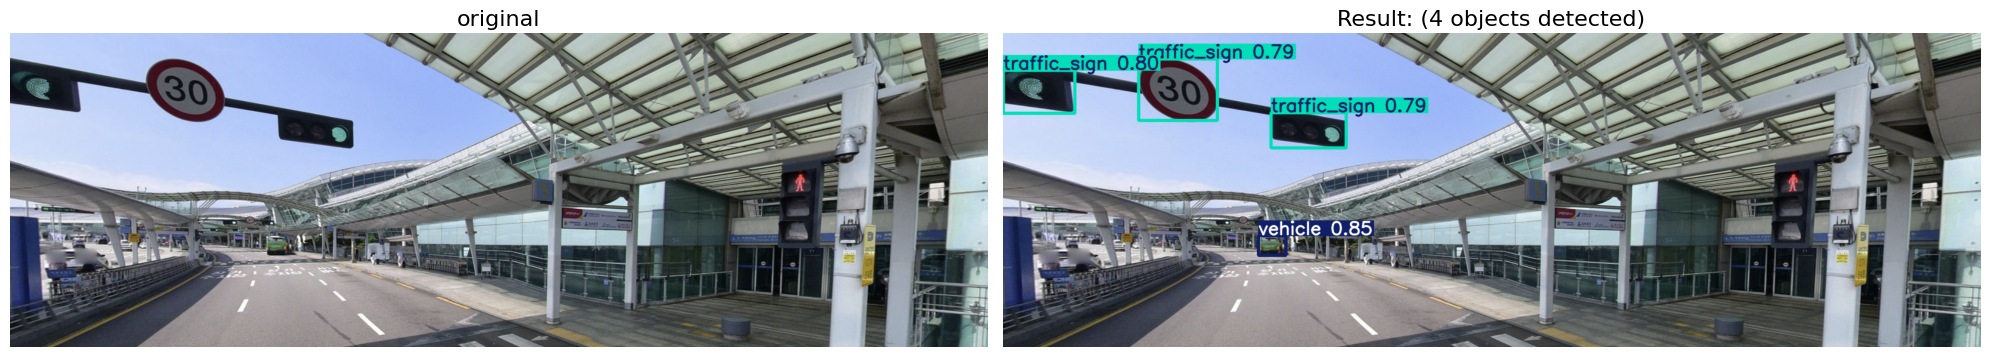


📊 감지된 객체 요약
  traffic_sign: 3개
  vehicle: 1개

  총 4개 객체

✅ 완료!
📁 저장된 파일: image2 (5)_prediction.txt
가까운 플랫폼 표지판 또는 안내 표지판이 보이는 방향으로 이동하세요. 기사님 위치까지 직진 이동을 계속하세요.
False /usr/bin/tesseract
[{'cls': 'traffic_sign', 'bbox_raw': [227, 43, 359, 146], 'bbox_exp': [121, 0, 464, 228], 'result': None}, {'cls': 'traffic_sign', 'bbox_raw': [0, 62, 120, 134], 'bbox_exp': [0, 4, 216, 191], 'result': None}]
total 1552
drwxr-xr-x 2 root root    4096 Jan 11 19:13 .
drwxr-xr-x 1 root root    4096 Jan 11 19:16 ..
-rw-r--r-- 1 root root 1355334 Jan 11 19:16 frame_with_boxes.png
-rw-r--r-- 1 root root   62743 Jan 11 19:16 traffic_sign_0_exp.png
-rw-r--r-- 1 root root   23142 Jan 11 19:16 traffic_sign_0_raw.png
-rw-r--r-- 1 root root   30430 Jan 11 19:16 traffic_sign_1_exp.png
-rw-r--r-- 1 root root   12967 Jan 11 19:16 traffic_sign_1_raw.png
-rw-r--r-- 1 root root   44802 Jan 11 19:16 traffic_sign_2_exp.png
-rw-r--r-- 1 root root   10674 Jan 11 19:16 traffic_sign_2_raw.png
-rw-r--r-- 1 root root   21625 Ja

In [ ]:
# ============================================================
# Step 1: 한글 폰트 설정
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import urllib.request

font_url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
font_path = "/usr/share/fonts/truetype/NanumGothic.ttf"

if not Path(font_path).exists():
    urllib.request.urlretrieve(font_url, font_path)

fm.fontManager.addfont(font_path)
fm._load_fontmanager(try_read_cache=False)

plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료!\n")

# ============================================================
# Step 2: 이미지 업로드 & 예측
# ============================================================

from google.colab import files
from ultralytics import YOLO
import cv2

print("📤 테스트 이미지를 업로드하세요!")
uploaded = files.upload()
img_name = list(uploaded.keys())[0]

print("\n🤖 모델 로드 중...")
best = YOLO(str(RUNS / "yolo_combined" / "weights" / "best.pt"))

print(f"🔍 '{img_name}' 예측 중...")
results = best.predict(source=img_name, imgsz=960, conf=0.25, verbose=False)

# ============================================================
# Step 3: 라벨 파일 생성 (YOLO 형식)
# ============================================================

# 이미지 크기
img = cv2.imread(img_name)
img_h, img_w = img.shape[:2]

# 라벨 파일 경로
label_path = Path(img_name).stem + "_prediction.txt"

# 라벨 저장
boxes = results[0].boxes
label_lines = []

for box in boxes:
    # 클래스 ID
    cls_id = int(box.cls[0])

    # 바운딩 박스 (xyxy → xywh 정규화)
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

    # 중심점 및 크기 계산
    cx = ((x1 + x2) / 2) / img_w
    cy = ((y1 + y2) / 2) / img_h
    w = (x2 - x1) / img_w
    h = (y2 - y1) / img_h

    # YOLO 형식: class_id cx cy w h
    label_lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

# 파일 저장
with open(label_path, 'w') as f:
    f.write("\n".join(label_lines))

print(f"💾 라벨 저장: {label_path}")

# ============================================================
# Step 4: 라벨 파일 내용 출력
# ============================================================

print("\n" + "="*60)
print(f"📄 라벨 파일 내용: {label_path}")
print("="*60)

if label_lines:
    print("\n[YOLO 형식: class_id center_x center_y width height]\n")

    for i, line in enumerate(label_lines, 1):
        parts = line.split()
        cls_id = int(parts[0])
        cls_name = CLASSES[cls_id]
        conf = float(boxes[i-1].conf[0])

        print(f"{i}. {line}")
        print(f"   → {cls_name} (신뢰도: {conf:.2%})")
        print()
else:
    print("(빈 파일 - 감지된 객체 없음)")

print("="*60)

# ============================================================
# Step 5: 시각화
# ============================================================

original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result_img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(original_img)
axes[0].set_title("original", fontsize=16)
axes[0].axis('off')

axes[1].imshow(result_img)
axes[1].set_title(f"Result: ({len(boxes)} objects detected)", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# ============================================================
# Step 6: 결과 요약
# ============================================================

print("\n" + "="*60)
print("📊 감지된 객체 요약")
print("="*60)

if len(boxes) > 0:
    from collections import Counter
    class_counts = Counter([CLASSES[int(box.cls[0])] for box in boxes])

    for cls_name, count in class_counts.most_common():
        print(f"  {cls_name}: {count}개")

    print(f"\n  총 {len(boxes)}개 객체")
else:
    print("❌ 감지된 객체 없음")

print("\n✅ 완료!")
print(f"📁 저장된 파일: {label_path}")

# ============================================================
# Step 7: 라벨 파일 다운로드 (선택사항)
# ============================================================
'''
print("\n💾 라벨 파일을 다운로드하시겠습니까?")
download = input("다운로드 (y/n): ").strip().lower()

if download == 'y':
    files.download(label_path)
    print("✅ 다운로드 완료!")
    '''
yolo_text = '\n'.join(label_lines)

import importlib, cv2
import pickup_guidance_engine as pge
importlib.reload(pge)
from pickup_guidance_engine import PickupGuidanceEngine, Pose


engine = PickupGuidanceEngine()
instruction, debug = engine.generate(
    image_bgr=img,
    yolo_label_text=yolo_text,
    passenger=Pose(lat=37.0, lon=127.0),
    driver=Pose(lat=37.0, lon=127.001),
    debug_dump_dir="/content/dbg_run"
)
print(instruction)
print(debug["tesseract_available"], debug["tesseract_bin"])
print(debug["ocr_debug"][:2])

!ls -al /content/dbg_run | head -n 200



In [ ]:
import cv2, traceback, os, importlib
import pickup_guidance_engine as pge
importlib.reload(pge)
from pickup_guidance_engine import PickupGuidanceEngine

# 이전 셀(8bhS9MKMcvCC)에서 생성된 text 변수 사용
if 'text' in locals():
    yolo_text = text
else:
    print("⚠️ 'text' 변수가 없습니다. 이전 셀을 실행해주세요.")
    yolo_text = ""

engine = PickupGuidanceEngine(debug_dump_default_dir=None)

print(f"Testing debug_dump with label text length: {len(yolo_text)}")

try:
    # img 변수는 이전 셀에서 로드된 이미지
    meta = engine.debug_dump(img, yolo_text, out_dir="/content/dbg30", max_per_class=20)
    print("✅ Debug dump successful!")
    print("Saved items count:", len(meta["saved"]))
    for item in meta["saved"]:
        print(f" - Saved: {item['cls']} (conf: {item['conf']:.2f}) -> {item['raw_path']}")
except Exception as e:
    print("❌ EXCEPTION OCCURRED:")
    traceback.print_exc()

print("\n=== ls /content/dbg30 (Check generated files) ===")
!ls -al /content/dbg30 | head -n 20

Testing debug_dump with label text length: 151
✅ Debug dump successful!
Saved items count: 4
 - Saved: vehicle (conf: 1.00) -> /content/dbg30/vehicle_0_raw.png
 - Saved: traffic_sign (conf: 1.00) -> /content/dbg30/traffic_sign_0_raw.png
 - Saved: traffic_sign (conf: 1.00) -> /content/dbg30/traffic_sign_1_raw.png
 - Saved: traffic_sign (conf: 1.00) -> /content/dbg30/traffic_sign_2_raw.png

=== ls /content/dbg30 (Check generated files) ===
total 1820
drwxr-xr-x 2 root root    4096 Jan 11 18:51 .
drwxr-xr-x 1 root root    4096 Jan 11 18:51 ..
-rw-r--r-- 1 root root 1355334 Jan 11 18:51 frame_with_boxes.png
-rw-r--r-- 1 root root   62743 Jan 11 18:51 traffic_sign_0_exp.png
-rw-r--r-- 1 root root   61237 Jan 11 18:51 traffic_sign_0_inner.png
-rw-r--r-- 1 root root  111531 Jan 11 18:51 traffic_sign_0_inner_var0.png
-rw-r--r-- 1 root root    9462 Jan 11 18:51 traffic_sign_0_inner_var1.png
-rw-r--r-- 1 root root    9358 Jan 11 18:51 traffic_sign_0_inner_var2.png
-rw-r--r-- 1 root root    6667 

In [ ]:
import os
OUT_DIR = "/content/dbg30"
os.makedirs(OUT_DIR, exist_ok=True)

print("Made:", OUT_DIR)
!ls -al /content | head -n 30
!ls -al /content/dbg30 | head -n 30


Made: /content/dbg30
total 15700
drwxr-xr-x 1 root root    4096 Jan 11 18:09 .
drwxr-xr-x 1 root root    4096 Jan 11 16:07 ..
drwxr-xr-x 4 root root    4096 Dec  9 14:41 .config
-rw-r--r-- 1 root root  114625 Jan 11 16:34 current_frame (1).jpg
-rw-r--r-- 1 root root     379 Jan 11 16:34 current_frame (1)_prediction.txt
-rw-r--r-- 1 root root  114625 Jan 11 16:34 current_frame.jpg
-rw-r--r-- 1 root root     379 Jan 11 16:34 current_frame_prediction.txt
drwxr-xr-x 2 root root    4096 Jan 11 18:08 dbg30
drwx------ 5 root root    4096 Jan 11 16:12 drive
-rw-r--r-- 1 root root 1352361 Jan 11 17:57 image (1).png
-rw-r--r-- 1 root root     341 Jan 11 17:57 image (1)_prediction.txt
-rw-r--r-- 1 root root 1440375 Jan 11 17:05 image2 (1).png
-rw-r--r-- 1 root root     151 Jan 11 17:05 image2 (1)_prediction.txt
-rw-r--r-- 1 root root 1440375 Jan 11 17:27 image2 (2).png
-rw-r--r-- 1 root root     151 Jan 11 17:27 image2 (2)_prediction.txt
-rw-r--r-- 1 root root 1440375 Jan 11 17:42 image2 (3).png
